# Chapter 2: Time Series With RNNS, LSTMS

In [84]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Fix random seed for reproducibility
np.random.seed(42)




## 1. Time Series with RNNs

We are creating  #batch size number fo time series each one with number of steps equal to number of steps: SO we are not creating only one tiem series that we want to predict. But actually we are creating many many (batch size)

In [85]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)     # Creating freq1, etc varibales each with batch size values
    time = np.linspace(0,1,n_steps)
    series = 0.5* np.sin((time-offsets1) * (freq1*10 + 10))  # Wave1
    series += 0.2 * np.sin((time-offsets2) * (freq2 *20 +20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) -0.5) # + noise
    return series[...,np.newaxis].astype(np.float32)

### Step 1: Creating the data

Series Shape: (10000, 51, 1)

 =============Training set=======
     - X_train Shape: (7000, 50, 1)
     - Y_train Shape: (7000, 1)

 =============Validation set=======
     - X_valid Shape: (2000, 50, 1)
     - Y_valid Shape: (2000, 1)

 =============Test set=======
     - X_test Shape: (1000, 1)
     - Y_test Shape: (1000, 1)


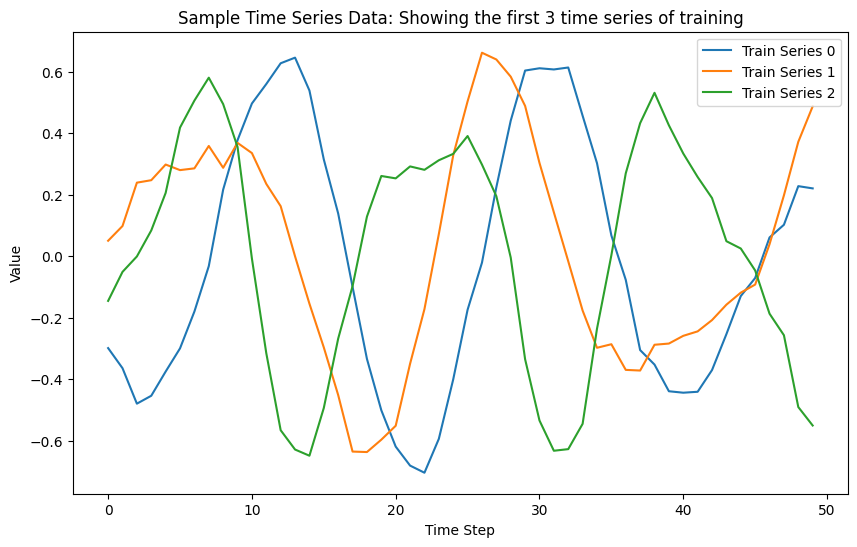

In [87]:
n_steps = 50
series = generate_time_series(10000, n_steps +1)
print(f"Series Shape: {series.shape}")
X_train, y_train = series[:7000,:n_steps], series[:7000,-1]
X_valid, y_valid = series[7000:9000,:n_steps], series[7000:9000,-1] # The Y value is only 1 value for each time series, (the 51 value to the forecasted)
X_test, y_test = series[9000:,n_steps], series[9000:, -1]

print(f"\n =============Training set=======")
print(f"     - X_train Shape: {X_train.shape}")
print(f"     - Y_train Shape: {y_train.shape}")

print(f"\n =============Validation set=======")
print(f"     - X_valid Shape: {X_valid.shape}")
print(f"     - Y_valid Shape: {y_valid.shape}")

print(f"\n =============Test set=======")
print(f"     - X_test Shape: {X_test.shape}")
print(f"     - Y_test Shape: {y_test.shape}")

# Plot some series
plt.figure(figsize=(10, 6))
for i in range(3):  # Plot 3 sample series
    plt.plot(X_train[i], label=f"Train Series {i}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Sample Time Series Data: Showing the first 3 time series of training")
plt.legend()
plt.show()


## Step 2: Baseline Models

In [88]:
# Model 1: Naive forecasting
y_pred = X_valid[:,-1]
mean_mse = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
print(f"\n Naive Forecasting Mean MSE: {mean_mse}")


 Naive Forecasting Mean MSE: 0.021024860441684723


Niave forecasting uses the 50 x element as prediction to the 51 x_element. 

Epoch 1/50


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0224 - val_loss: 0.0054
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

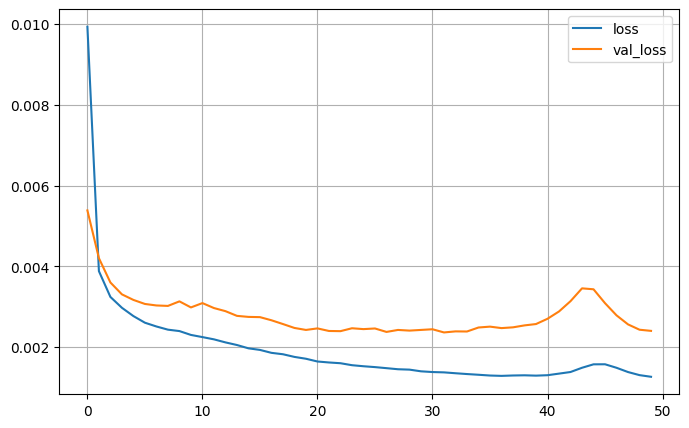

In [89]:
# Model 2: FNN

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(),
              loss = "mse")

history = model.fit(X_train, y_train,
          epochs = 50,
          validation_data = (X_valid, y_valid))
model.evaluate(X_valid, y_valid)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()


## Step 3: RNN

### 3.1: Basic RNN with 1 Cell

Epoch 1/50


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3956 - val_loss: 0.2404
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2172 - val_loss: 0.2010
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1814 - val_loss: 0.1633
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1505 - val_loss: 0.1435
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1403 - val_loss: 0.1458
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1369 - val_loss: 0.1404
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1391 - val_loss: 0.1431
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1389 - val_loss: 0.1410
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1380 - val_loss: 0.1405
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1383 - val_loss: 0.1402
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1396 - val_loss: 0.1429
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

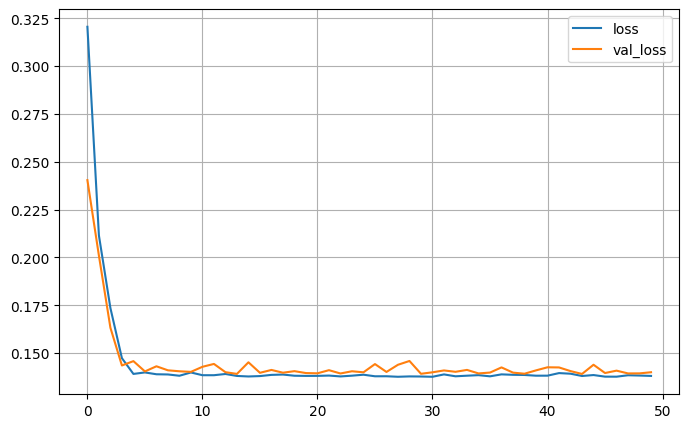

In [37]:
# Model 1: Basic RNN

model_simple_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,1])   # No need to specifcy teh input shape , as it can do it by itseld
])

model_simple_rnn.compile(optimizer=keras.optimizers.Adam(),
              loss = "mse")

history = model_simple_rnn.fit(X_train, y_train,
          epochs = 50,
          validation_data = (X_valid, y_valid))
model_simple_rnn.evaluate(X_valid, y_valid)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### 3.2 Deeper RNN: 1 Value prediction

Epoch 1/50


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0529 - val_loss: 0.0049
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/ste

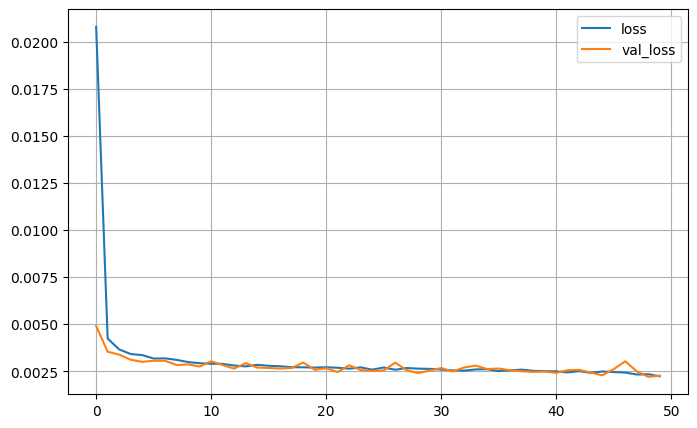

In [38]:
# Model 2: Deep RNN. Using only SimpleRNN

model_deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),   # No need to specifcy teh input shape , as it can do it by itseld
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model_deep_rnn.compile(optimizer=keras.optimizers.Adam(),
              loss = "mse")

history = model_deep_rnn.fit(X_train, y_train,
          epochs = 50,
          validation_data = (X_valid, y_valid))
model_deep_rnn.evaluate(X_valid, y_valid)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Epoch 1/50


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0959 - val_loss: 0.0058
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0

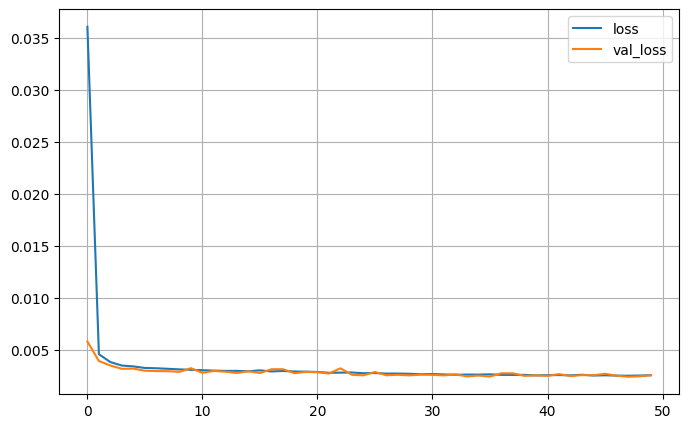

In [40]:
# Model 2: Deep RNN. Using Dense layer at the output layer

model_deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),   # No need to specifcy teh input shape , as it can do it by itseld
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_deep_rnn.compile(optimizer=keras.optimizers.Adam(),
              loss = "mse")

history = model_deep_rnn.fit(X_train, y_train,
          epochs = 50,
          validation_data = (X_valid, y_valid))
model_deep_rnn.evaluate(X_valid, y_valid)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Step 4: Forecasting Several Times Ahead

### 4.1 Deeper RNN: 1 Value prediction used to predict next 10 values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean Squared Error (MSE): 0.0210


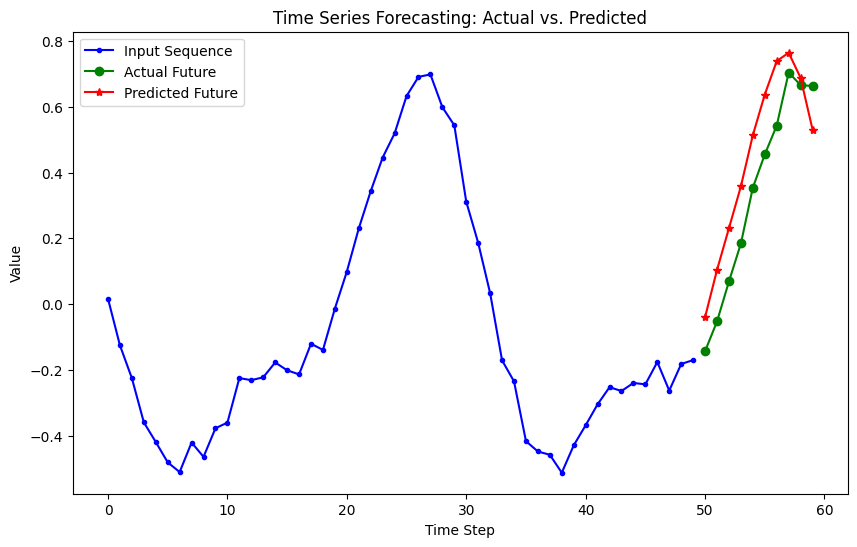

In [44]:
# Using the RNN model to predict 1 temestep, to predict 10 next predictions (1 by 1)
series = generate_time_series(1, n_steps +10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:,step_ahead:])[:, np.newaxis,:]
    X=np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]



from sklearn.metrics import mean_squared_error

# Compute MSE between actual future values and predicted future values
mse = mean_squared_error(Y_new[0, :, 0], Y_pred[0, :, 0])
print(f"Mean Squared Error (MSE): {mse:.4f}")


# Plotting
# Plot actual vs predicted series
plt.figure(figsize=(10, 6))
time_axis = np.arange(n_steps + 10)

plt.plot(time_axis[:n_steps], X_new[0, :, 0], "b.-", label="Input Sequence")
plt.plot(time_axis[n_steps:], Y_new[0, :, 0], "go-", label="Actual Future")
plt.plot(time_axis[n_steps:], Y_pred[0, :, 0], "r*-", label="Predicted Future")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Time Series Forecasting: Actual vs. Predicted")
plt.legend()
plt.show()



### 4.2 Deeper RNN: Predict the next 10 values only at the end (after n_steps)


 =============Training set=======
     - X_train Shape: (7000, 50, 1)
     - Y_train Shape: (7000, 10)

 =============Validation set=======
     - X_valid Shape: (2000, 50, 1)
     - Y_valid Shape: (2000, 10)

 =============Test set=======
     - X_test Shape: (1000, 50, 1)
     - Y_test Shape: (1000, 10)
Epoch 1/20


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1127 - val_loss: 0.0332
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0296 - val_loss: 0.0198
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0191 - val_loss: 0.0159
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158 - val_loss: 0.0136
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0143 - val_loss: 0.0127
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0116 - val_loss: 0.0130
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

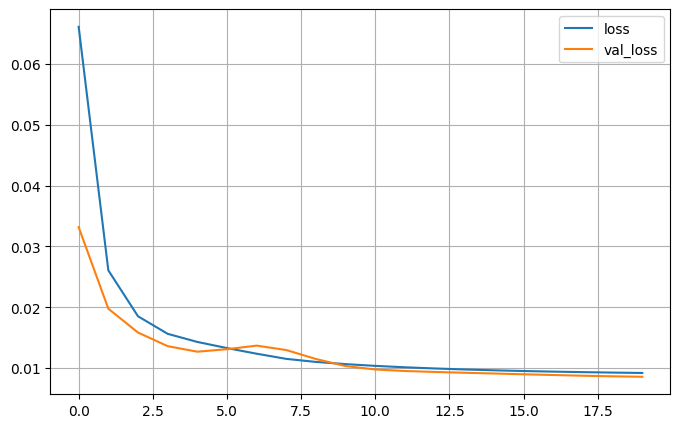

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


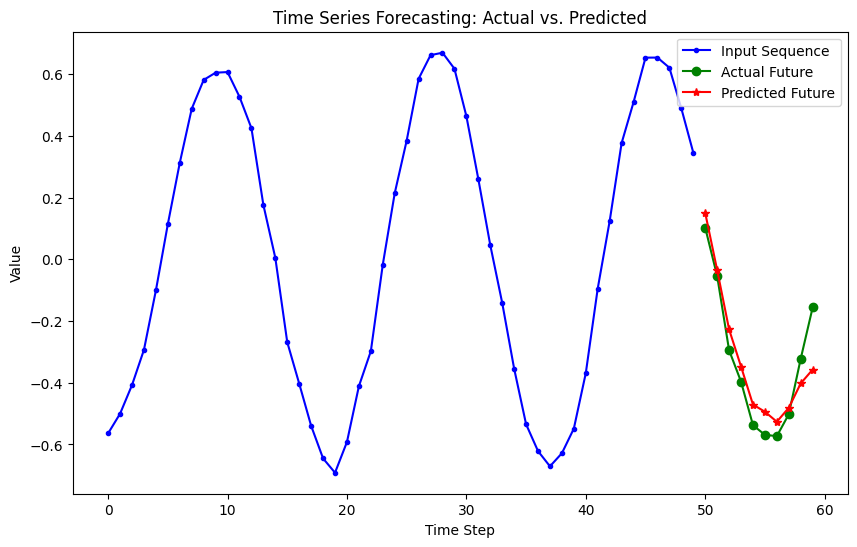

In [92]:
# Using a new model to predict directly the next 10 times, but only at the last timestep (not ideal)

# 1. data:
np.random.seed(42)


n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]    # only using teh last 10 points after n_steps as y_labels to be predicted
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

print(f"\n =============Training set=======")
print(f"     - X_train Shape: {X_train.shape}")
print(f"     - Y_train Shape: {y_train.shape}")

print(f"\n =============Validation set=======")
print(f"     - X_valid Shape: {X_valid.shape}")
print(f"     - Y_valid Shape: {y_valid.shape}")

print(f"\n =============Test set=======")
print(f"     - X_test Shape: {X_test.shape}")
print(f"     - Y_test Shape: {y_test.shape}")


# 2. Model
# Model 2: Deep RNN. Using Dense layer at the output layer. Not working

model_deep_10_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),   # No need to specifcy teh input shape , as it can do it by itseld
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)    # To predict t
])

model_deep_10_rnn.compile(optimizer=keras.optimizers.Adam(),
              loss = "mse")

history = model_deep_10_rnn.fit(X_train, y_train,
          epochs = 20,
          validation_data = (X_valid, y_valid))
model_deep_10_rnn.evaluate(X_valid, y_valid)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# test

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_deep_10_rnn.predict(X_new)[..., np.newaxis]


# Plotting
# Plot actual vs predicted series
plt.figure(figsize=(10, 6))
time_axis = np.arange(n_steps + 10)

plt.plot(time_axis[:n_steps], X_new[0, :, 0], "b.-", label="Input Sequence")
plt.plot(time_axis[n_steps:], Y_new[0, :, 0], "go-", label="Actual Future")
plt.plot(time_axis[n_steps:], Y_pred[0, :], "r*-", label="Predicted Future")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Time Series Forecasting: Actual vs. Predicted")
plt.legend()
plt.show()





### 4.3 Deeper RNN: Predict the next 10 values always (step 0: predict values from 1 to 10), (step1: Predicts values from 2 to 11)


 =============Training set=======
     - X_train Shape: (7000, 50, 1)
     - Y_train Shape: (7000, 50, 10)

 =============Validation set=======
     - X_valid Shape: (2000, 50, 1)
     - Y_valid Shape: (2000, 50, 10)

 =============Test set=======
     - X_test Shape: (1000, 50, 1)
     - Y_test Shape: (1000, 50, 10)
Epoch 1/20


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0718 - loss: 0.0814 - val_last_time_step_mse: 0.0311 - val_loss: 0.0428
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0301 - loss: 0.0417 - val_last_time_step_mse: 0.0224 - val_loss: 0.0345
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0227 - loss: 0.0350 - val_last_time_step_mse: 0.0166 - val_loss: 0.0294
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0192 - loss: 0.0310 - val_last_time_step_mse: 0.0159 - val_loss: 0.0280
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0170 - loss: 0.0288 - val_last_time_step_mse: 0.0127 - val_loss: 0.0255
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0132 - loss: 0.0261 - val_last_time_step_mse: 0.0160 - val_loss: 0.0264
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0108 - loss: 0.0238 - val_last_time_step_mse:

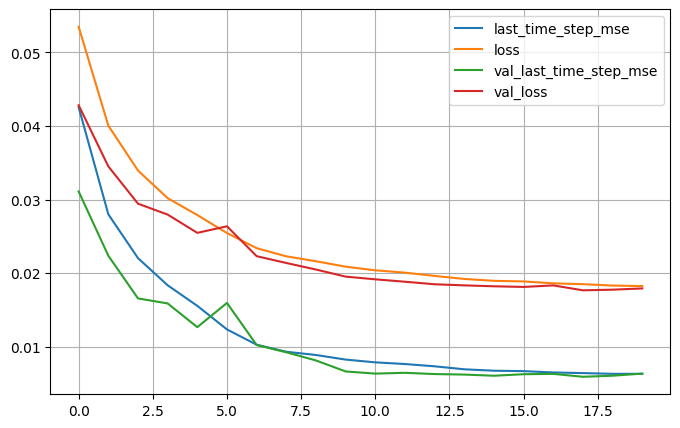

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step

 =============== Shapes===================
    - X_new: (1, 50, 1)
    - Y_new: (1, 10, 1)
    - Y_pred: (1, 10, 1)


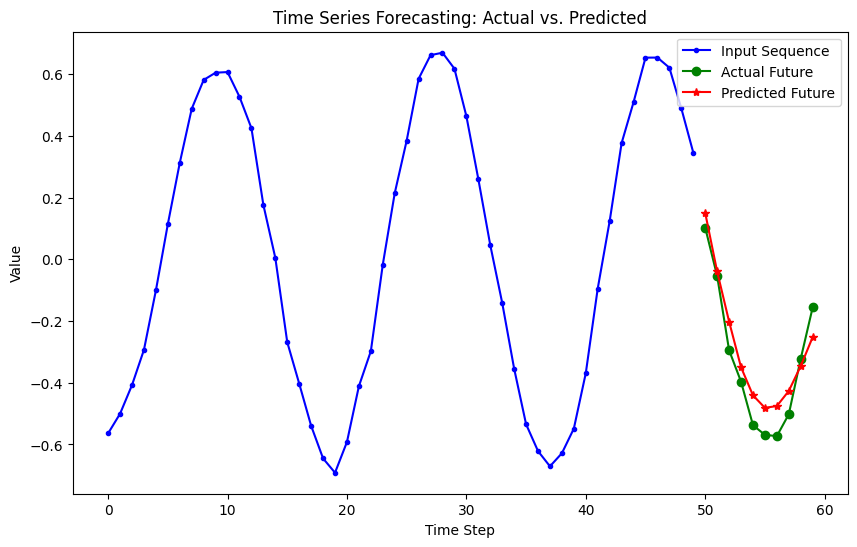

In [106]:
# Using a new model to predict directly the next 10 times, but only at the last timestep (not ideal)

# 1. data:
np.random.seed(42)


np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


print(f"\n =============Training set=======")
print(f"     - X_train Shape: {X_train.shape}")
print(f"     - Y_train Shape: {Y_train.shape}")

print(f"\n =============Validation set=======")
print(f"     - X_valid Shape: {X_valid.shape}")
print(f"     - Y_valid Shape: {Y_valid.shape}")

print(f"\n =============Test set=======")
print(f"     - X_test Shape: {X_test.shape}")
print(f"     - Y_test Shape: {Y_test.shape}")


# 2. Model
# Model 2: Deep RNN. Using Dense layer at the output layer. Not working

model_deep_10_complete_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),   # No need to specifcy teh input shape , as it can do it by itseld
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))    # To predict t
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model_deep_10_complete_rnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss = "mse",metrics=[last_time_step_mse]
                         )

history = model_deep_10_complete_rnn.fit(X_train, Y_train,
          epochs = 20,
          validation_data = (X_valid, Y_valid))
model_deep_10_complete_rnn.evaluate(X_test, Y_test)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# test

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_deep_10_complete_rnn.predict(X_new)[:, -1][..., np.newaxis]

print(f"\n =============== Shapes===================")
print(f"    - X_new: {X_new.shape}")
print(f"    - Y_new: {Y_new.shape}")
print(f"    - Y_pred: {Y_pred.shape}")


# Plotting
# Plot actual vs predicted series
plt.figure(figsize=(10, 6))
time_axis = np.arange(n_steps + 10)

plt.plot(time_axis[:n_steps], X_new[0, :, 0], "b.-", label="Input Sequence")
plt.plot(time_axis[n_steps:], Y_new[0, :, 0], "go-", label="Actual Future")
plt.plot(time_axis[n_steps:], Y_pred[0, :], "r*-", label="Predicted Future")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Time Series Forecasting: Actual vs. Predicted")
plt.legend()
plt.show()





## Step 9: LSTM: Predicting the next 10 values


 =============Training set=======
     - X_train Shape: (7000, 50, 1)
     - Y_train Shape: (7000, 50, 10)

 =============Validation set=======
     - X_valid Shape: (2000, 50, 1)
     - Y_valid Shape: (2000, 50, 10)

 =============Test set=======
     - X_test Shape: (1000, 50, 1)
     - Y_test Shape: (1000, 50, 10)
Epoch 1/20


C:\Users\pierg\Documents\Github\Hands-On-Machine-Learning\handsOnMachineLearning_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - last_time_step_mse: 0.0561 - loss: 0.0681 - val_last_time_step_mse: 0.0132 - val_loss: 0.0291
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0127 - loss: 0.0280 - val_last_time_step_mse: 0.0077 - val_loss: 0.0236
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0073 - loss: 0.0226 - val_last_time_step_mse: 0.0055 - val_loss: 0.0197
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0054 - loss: 0.0193 - val_last_time_step_mse: 0.0040 - val_loss: 0.0173
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0046 - loss: 0.0175 - val_last_time_step_mse: 0.0046 - val_loss: 0.0168
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0041 - loss: 0.0165 - val_last_time_step_mse: 0.0040 - val_loss: 0.0158
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0038 - loss: 0.0158 - val_last_time_step

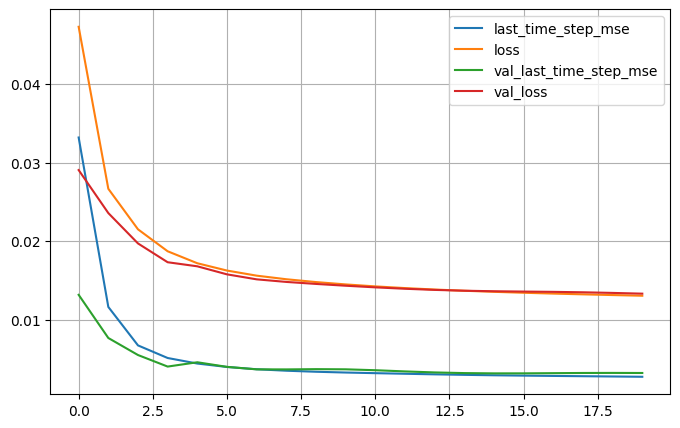

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step

 =============== Shapes===================
    - X_new: (1, 50, 1)
    - Y_new: (1, 10, 1)
    - Y_pred: (1, 10, 1)


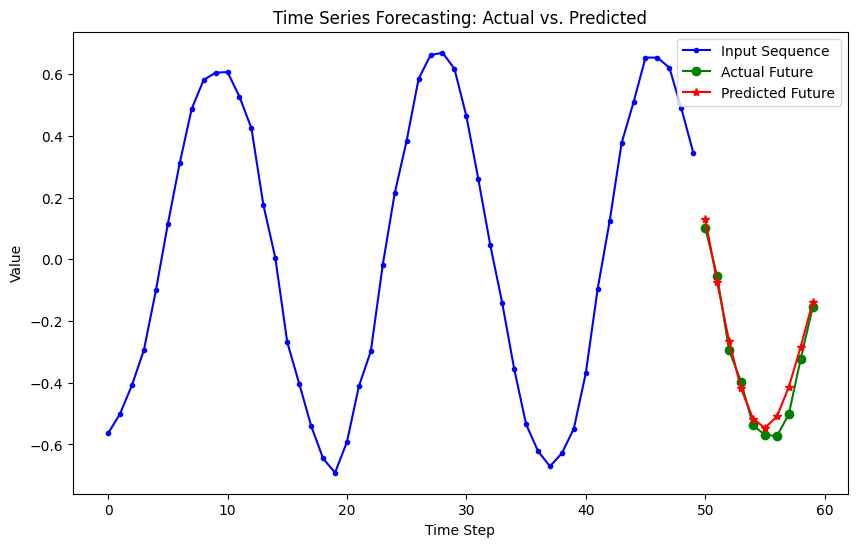

In [107]:
np.random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

n_steps = 50
# Prepare Y for each step ahead (1 to 10)
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]





# Using a new model to predict directly the next 10 times, but only at the last timestep (not ideal)

# 1. data:
np.random.seed(42)


np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


print(f"\n =============Training set=======")
print(f"     - X_train Shape: {X_train.shape}")
print(f"     - Y_train Shape: {Y_train.shape}")

print(f"\n =============Validation set=======")
print(f"     - X_valid Shape: {X_valid.shape}")
print(f"     - Y_valid Shape: {Y_valid.shape}")

print(f"\n =============Test set=======")
print(f"     - X_test Shape: {X_test.shape}")
print(f"     - Y_test Shape: {Y_test.shape}")


# 2. Model
# Model 3: LSTM

# Build and compile the model
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model_lstm .compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss = "mse",metrics=[last_time_step_mse]
                         )

history = model_lstm .fit(X_train, Y_train,
          epochs = 20,
          validation_data = (X_valid, Y_valid))
model_lstm.evaluate(X_test, Y_test)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# test

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model_lstm.predict(X_new)[:, -1][..., np.newaxis]

print(f"\n =============== Shapes===================")
print(f"    - X_new: {X_new.shape}")
print(f"    - Y_new: {Y_new.shape}")
print(f"    - Y_pred: {Y_pred.shape}")


# Plotting
# Plot actual vs predicted series
plt.figure(figsize=(10, 6))
time_axis = np.arange(n_steps + 10)

plt.plot(time_axis[:n_steps], X_new[0, :, 0], "b.-", label="Input Sequence")
plt.plot(time_axis[n_steps:], Y_new[0, :, 0], "go-", label="Actual Future")
plt.plot(time_axis[n_steps:], Y_pred[0, :], "r*-", label="Predicted Future")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Time Series Forecasting: Actual vs. Predicted")
plt.legend()
plt.show()




